
*Full Name:* Shahin Shahnavaz

*SID:* 810800013

Libs

In [46]:
import os
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score, davies_bouldin_score, homogeneity_score


Loading Datas

In [4]:
dataset_path = "dataset.csv"
data = pd.read_csv(dataset_path, encoding='latin1', header=None, names=["Text"])

print("Preview of the first 5 entries:")
print(data.head())

print("\nDataset overview:")
print(data.info())

print("\nSummary statistics:")
print(data.describe())

Preview of the first 5 entries:
                                                Text
0                                           document
1  From: melabdel@cobra.cs.unm.edu (Mohammed Elab...
2  From: bc744@cleveland.Freenet.Edu (Mark Ira Ka...
3  From: lundby@rtsg.mot.com (Walter F. Lundby)\n...
4  From: ajs8@kimbark.uchicago.edu (adam jeremy s...

Dataset overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3898 entries, 0 to 3897
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    3898 non-null   object
dtypes: object(1)
memory usage: 30.6+ KB
None

Summary statistics:
                                                     Text
count                                                3898
unique                                               3898
top     From: "Gabriel D. Underwood" <gabe+@CMU.EDU>\n...
freq                                                    1


### Pre Processing Part:

1. 
Stemming involves chopping off the ends of words to remove suffixes and prefixes, often resulting in a crude root form (called a "stem"). 
Example: The word "running" might be reduced to "run," and "jumps" might be reduced to "jump."
Pros: Fast and computationally less expensive.
Cons: May produce stems that are not actual words (e.g., "argue" and "argument" might both be stemmed to "argu").

Lemmatization reduces words to their base or dictionary form (called a "lemma") using vocabulary and morphological analysis. It considers the context and part of speech to return a valid word.
Example: The word "better" would be lemmatized to "good," and "running" would be lemmatized to "run."
Pros: Produces valid words and is more accurate than stemming.
Cons: Slower and more computationally expensive than stemming.

2. 
Preprocessing is essential for transforming raw data into a clean, structured format suitable for analysis and modeling. It improves data quality by removing noise, handling missing values, and correcting errors. Standardization techniques like normalization, tokenization, and case normalization ensure uniformity. Dimensionality reduction through feature selection, stemming, and stopword removal simplifies data. Preprocessing enhances model performance by improving accuracy, reducing overfitting, and speeding up training. It also ensures compatibility with algorithms and tools, enabling better insights and pattern discovery. Overall, preprocessing is a critical step to ensure reliable and accurate results in data analysis and machine learning.

3. 
Feature extraction is essential because raw text is unstructured and incompatible with most machine learning algorithms, which require numerical input. It transforms text into structured formats like TF-IDF or word embeddings, capturing meaning, context, and relationships. By reducing dimensionality, it removes noise and irrelevant information, making data processing more efficient. Feature extraction also improves model performance by focusing on meaningful patterns and enabling faster analysis. Without it, raw text's high dimensionality, noise, and lack of structure would hinder accurate and effective machine learning.

In [5]:
# Download required NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Set up preprocessing tools
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Define a function to clean and process text
def clean_and_process(text):
    # Normalize whitespace and remove special characters
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    
    # Convert text to lowercase
    text = text.lower()
    
    # Split text into individual words
    words = text.split()
    
    # Filter out stopwords
    words = [word for word in words if word not in stop_words]
    
    # Apply stemming to reduce words to their root forms
    words = [stemmer.stem(word) for word in words]
    
    # Apply lemmatization to get dictionary forms of words
    words = [lemmatizer.lemmatize(word) for word in words]
    
    # Combine words back into a single string
    return ' '.join(words)

# Apply the preprocessing function to the dataset
data['Cleaned_Text'] = data['Text'].apply(clean_and_process)  # Fixed: Changed "Document" to "Text"

# Show the first few rows of the processed data
print(data.head())

[nltk_data] Downloading package stopwords to C:\Users\Shahin
[nltk_data]     Shahnavaz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Shahin
[nltk_data]     Shahnavaz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Shahin
[nltk_data]     Shahnavaz\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


                                                Text  \
0                                           document   
1  From: melabdel@cobra.cs.unm.edu (Mohammed Elab...   
2  From: bc744@cleveland.Freenet.Edu (Mark Ira Ka...   
3  From: lundby@rtsg.mot.com (Walter F. Lundby)\n...   
4  From: ajs8@kimbark.uchicago.edu (adam jeremy s...   

                                        Cleaned_Text  
0                                           document  
1  melabdelcobracsunmedu moham elabdellaoui subje...  
2  bc744clevelandfreenetedu mark ira kaufman subj...  
3  lundbyrtsgmotcom walter f lundbi subject msg s...  
4  ajs8kimbarkuchicagoedu adam jeremi schorr subj...  


### Problem Process

In [8]:
os.environ['HF_HUB_DISABLE_SYMLINKS_WARNING'] = '1'

tfidf = TfidfVectorizer(max_features=500)
tfidf_features = tfidf.fit_transform(data['Cleaned_Text'])
tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=tfidf.get_feature_names_out())
print("TF-IDF Feature Matrix:")
print(tfidf_df.head())


# Load a pre-trained SentenceTransformer model
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings for the preprocessed text
embeddings = embedding_model.encode(data['Cleaned_Text'])

# Display the shape of the embeddings
print("Sentence Embeddings Shape:", embeddings.shape)

# Load the dataset
dataset_path = "dataset.csv"  # Update with your dataset path
data = pd.read_csv(dataset_path, encoding='latin1', header=None, names=["Text"])

# Load the SentenceTransformer model
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate feature vectors for each document
data['Feature_Vector'] = data['Text'].apply(lambda x: embedding_model.encode(x))

# Convert the list of feature vectors into a 2D array
feature_matrix = np.array(data['Feature_Vector'].tolist())

# Display the shape of the feature matrix
print("Feature Matrix Shape:", feature_matrix.shape)

TF-IDF Feature Matrix:
    10   11        12   13   14   15   16  1992  1993   20  ...     world  \
0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0   0.0   0.0  0.0  ...  0.000000   
1  0.0  0.0  0.000000  0.0  0.0  0.0  0.0   0.0   0.0  0.0  ...  0.068641   
2  0.0  0.0  0.152894  0.0  0.0  0.0  0.0   0.0   0.0  0.0  ...  0.000000   
3  0.0  0.0  0.070785  0.0  0.0  0.0  0.0   0.0   0.0  0.0  ...  0.000000   
4  0.0  0.0  0.000000  0.0  0.0  0.0  0.0   0.0   0.0  0.0  ...  0.000000   

      would     write  wrong  wrote   ye  year  yet  york  your  
0  0.000000  0.000000    0.0    0.0  0.0   0.0  0.0   0.0   0.0  
1  0.106355  0.082984    0.0    0.0  0.0   0.0  0.0   0.0   0.0  
2  0.343574  0.000000    0.0    0.0  0.0   0.0  0.0   0.0   0.0  
3  0.000000  0.000000    0.0    0.0  0.0   0.0  0.0   0.0   0.0  
4  0.000000  0.000000    0.0    0.0  0.0   0.0  0.0   0.0   0.0  

[5 rows x 500 columns]
Sentence Embeddings Shape: (3898, 384)
Feature Matrix Shape: (3898, 384)


4. 
Supervised Learning:
Definition: The model learns from labeled data, where the input data (features) is paired with the correct output (labels).

Goal: Predict the output for new, unseen data based on patterns learned from the training data.

Examples: Classification (e.g., spam detection), Regression (e.g., predicting house prices).

Key Point: Requires labeled data for training.

Unsupervised Learning:
Definition: The model learns from unlabeled data, where only the input data (features) is provided without any output labels.

Goal: Discover hidden patterns, structures, or groupings in the data.

Examples: Clustering (e.g., customer segmentation), Dimensionality Reduction (e.g., PCA).

Key Point: Works with unlabeled data, focusing on exploring the data's inherent structure.

Key Difference:
Supervised Learning uses labeled data to make predictions.

Unsupervised Learning explores unlabeled data to find patterns or groupings.

5.
Numerical Representation: Convert raw data (e.g., text, images) into numerical form for machine learning algorithms to process.
Dimensionality Reduction: Simplify complex data by capturing the most important features, reducing noise and redundancy.
Capture Patterns: Represent data in a way that highlights meaningful patterns, relationships, or structures.
Algorithm Compatibility: Most machine learning algorithms require numerical input, and feature vectors provide this in a structured format.
Efficiency: Improve computational efficiency by reducing the size and complexity of the data while retaining essential information.

6.
Sentence Transformers:
- Definition: A framework for generating dense vector representations (embeddings) of sentences or text snippets.
- Purpose: Captures semantic meaning, enabling tasks like semantic search, clustering, and text similarity.
- How It Works: Uses transformer-based models (e.g., BERT) fine-tuned on sentence-level tasks to produce meaningful embeddings.

all-MiniLM-L6-v2:
- Model: A lightweight, efficient version of Sentence Transformers.
- Features:
  - Small Size: Optimized for speed and lower resource usage.
  - High Performance: Maintains strong semantic representation despite its compact design.
- Use Cases: Ideal for applications requiring fast and accurate sentence embeddings, such as semantic search or clustering.

7.
Comparison of Clustering Methods:
K-Means:
   - Pros: Fast, scalable, works well with large datasets.
   - Cons: Requires predefined number of clusters (`k`), sensitive to outliers, assumes spherical clusters.

Hierarchical Clustering:
   - Pros: No need to specify `k`, produces a dendrogram for cluster exploration.
   - Cons: Computationally expensive for large datasets, sensitive to noise.

DBSCAN:
   - Pros: No need to specify `k`, handles noise and outliers, finds arbitrarily shaped clusters.
   - Cons: Struggles with varying density, requires careful tuning of `eps` and `min_samples`.

Gaussian Mixture Models (GMM)**:
   - Pros: Can model clusters of different shapes and sizes, provides probabilistic cluster assignments.
   - Cons: Computationally intensive, sensitive to initialization.

Agglomerative Clustering:
   - Pros: Hierarchical approach, works well with small to medium datasets.
   - Cons: Not scalable for large datasets, sensitive to noise.

Key Consideration:
- Choose based on dataset size, cluster shape, noise tolerance, and need for scalability.


8.
Elbow Method in K-Means:
- Purpose: Determines the optimal number of clusters (`k`) by balancing model complexity and clustering quality.
- How It Works: Plots the **inertia** (sum of squared distances to cluster centers) against different values of `k`.
- Optimal `k`: The "elbow" point where inertia starts to decrease more slowly, indicating diminishing returns.
- Use Case: Helps avoid overfitting (too many clusters) or underfitting (too few clusters).

9. 
Comparing Clustering Results:
- Visual Inspection: Use dimensionality reduction (e.g., PCA, t-SNE) to plot clusters and assess separation.
- Internal Metrics: Evaluate using metrics like **Silhouette Score** (cluster cohesion and separation) or **Davies-Bouldin Index** (cluster compactness).
- Stability: Check consistency of results across different runs or parameter settings.
- Domain Knowledge: Validate clusters against real-world context or labeled data (if available).
- Algorithm-Specific Metrics: Use metrics like inertia (K-Means) or density (DBSCAN) for method-specific evaluation.



### K means:

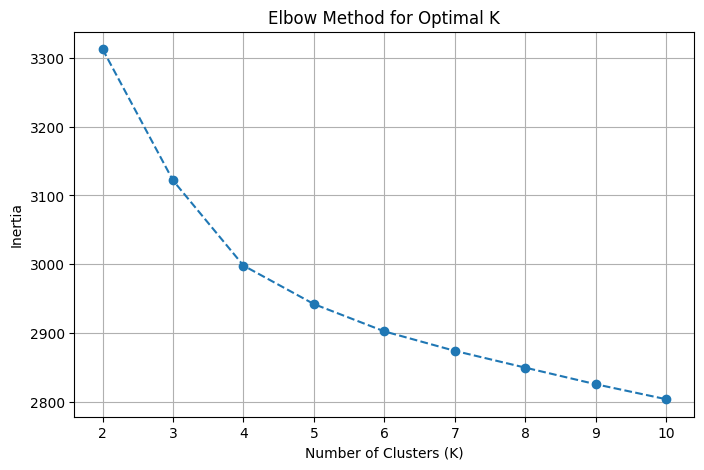

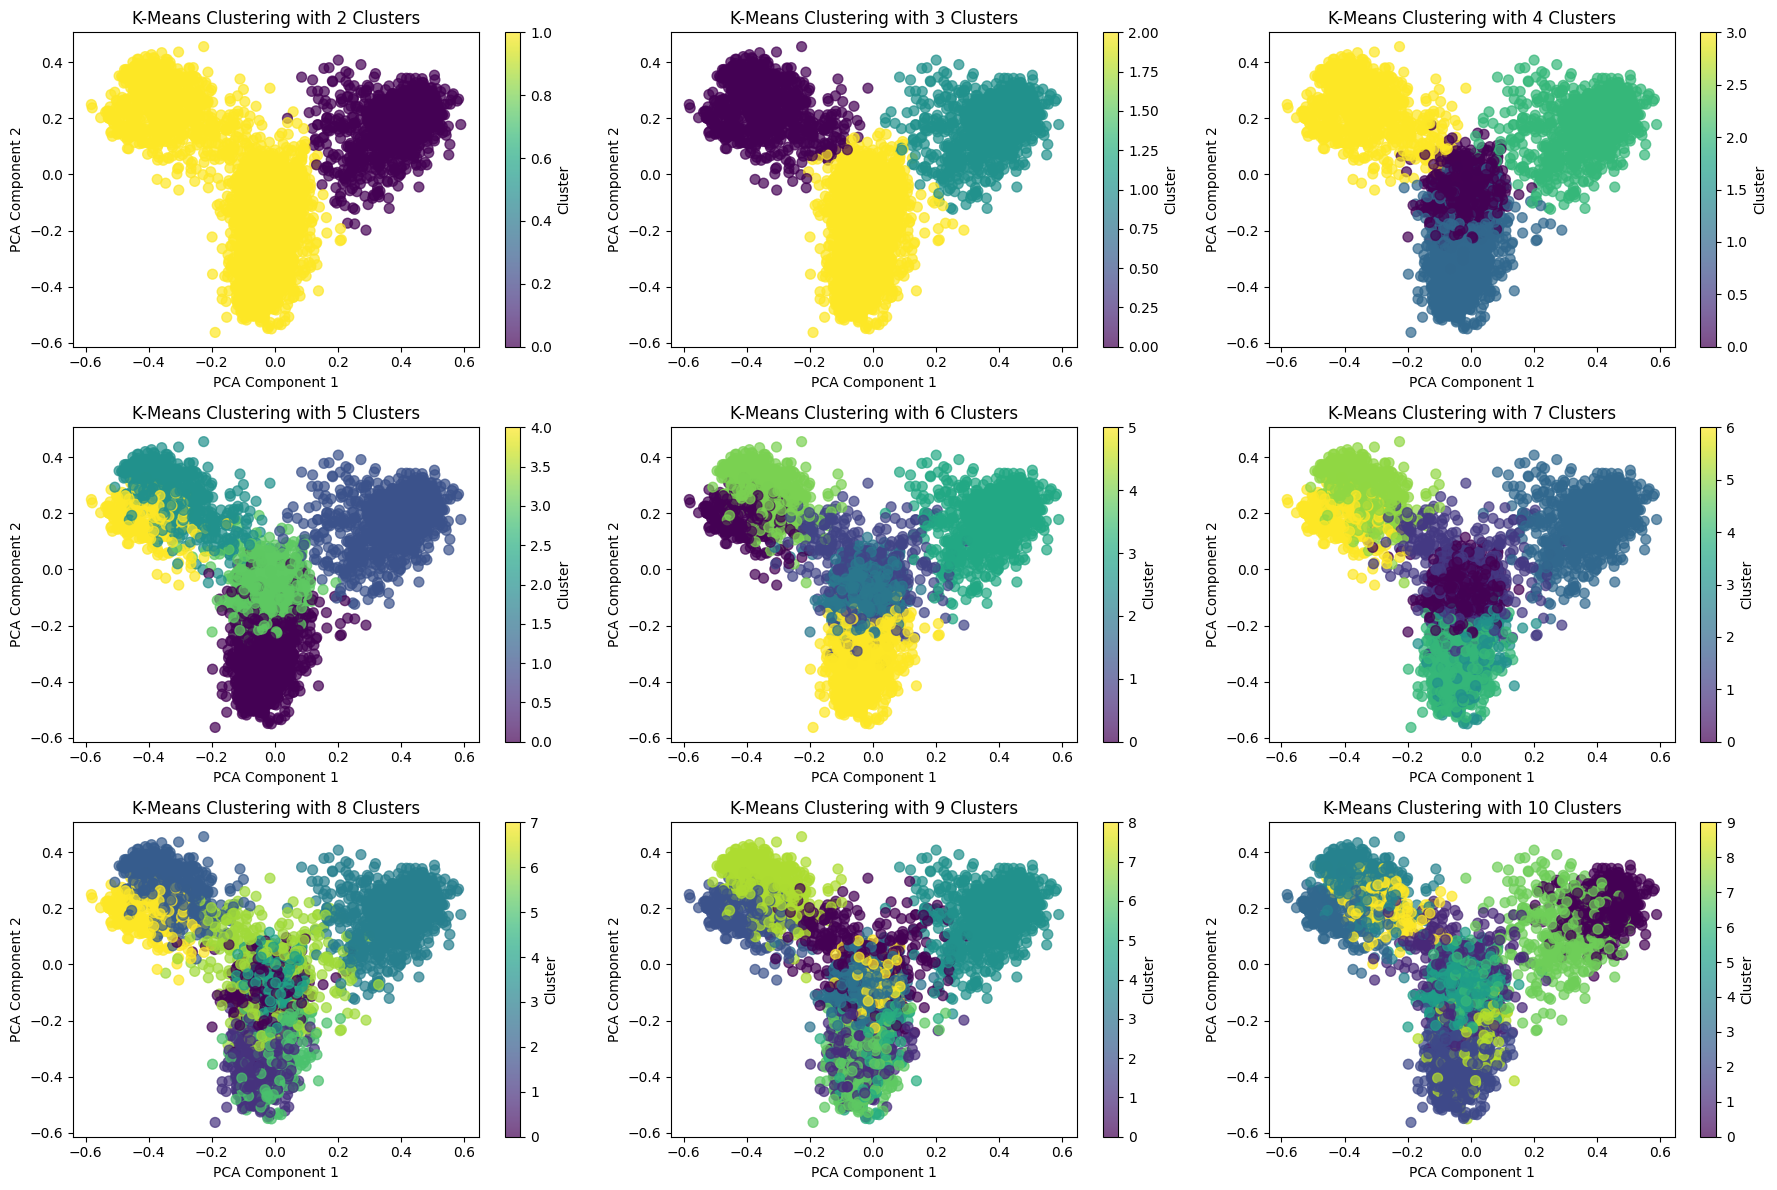

In [ ]:
# Elbow Method to determine optimal K
inertia = []
K_range = range(2, 11)  # Test K values from 2 to 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)  # n_init to avoid convergence warnings
    kmeans.fit(feature_matrix)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.xticks(K_range)
plt.grid(True)
plt.show()

# Reduce dimensionality for visualization using PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(feature_matrix)

# Plot clustering results for different K values
plt.figure(figsize=(18, 12))

for i, k in enumerate(K_range):
    # Fit K-Means with current K
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(feature_matrix)
    
    # Add subplot for current K
    plt.subplot(3, 3, i + 1)
    plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis', s=50, alpha=0.7)
    plt.title(f"K-Means Clustering with {k} Clusters")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.colorbar(label="Cluster")

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

### DBSCAN 

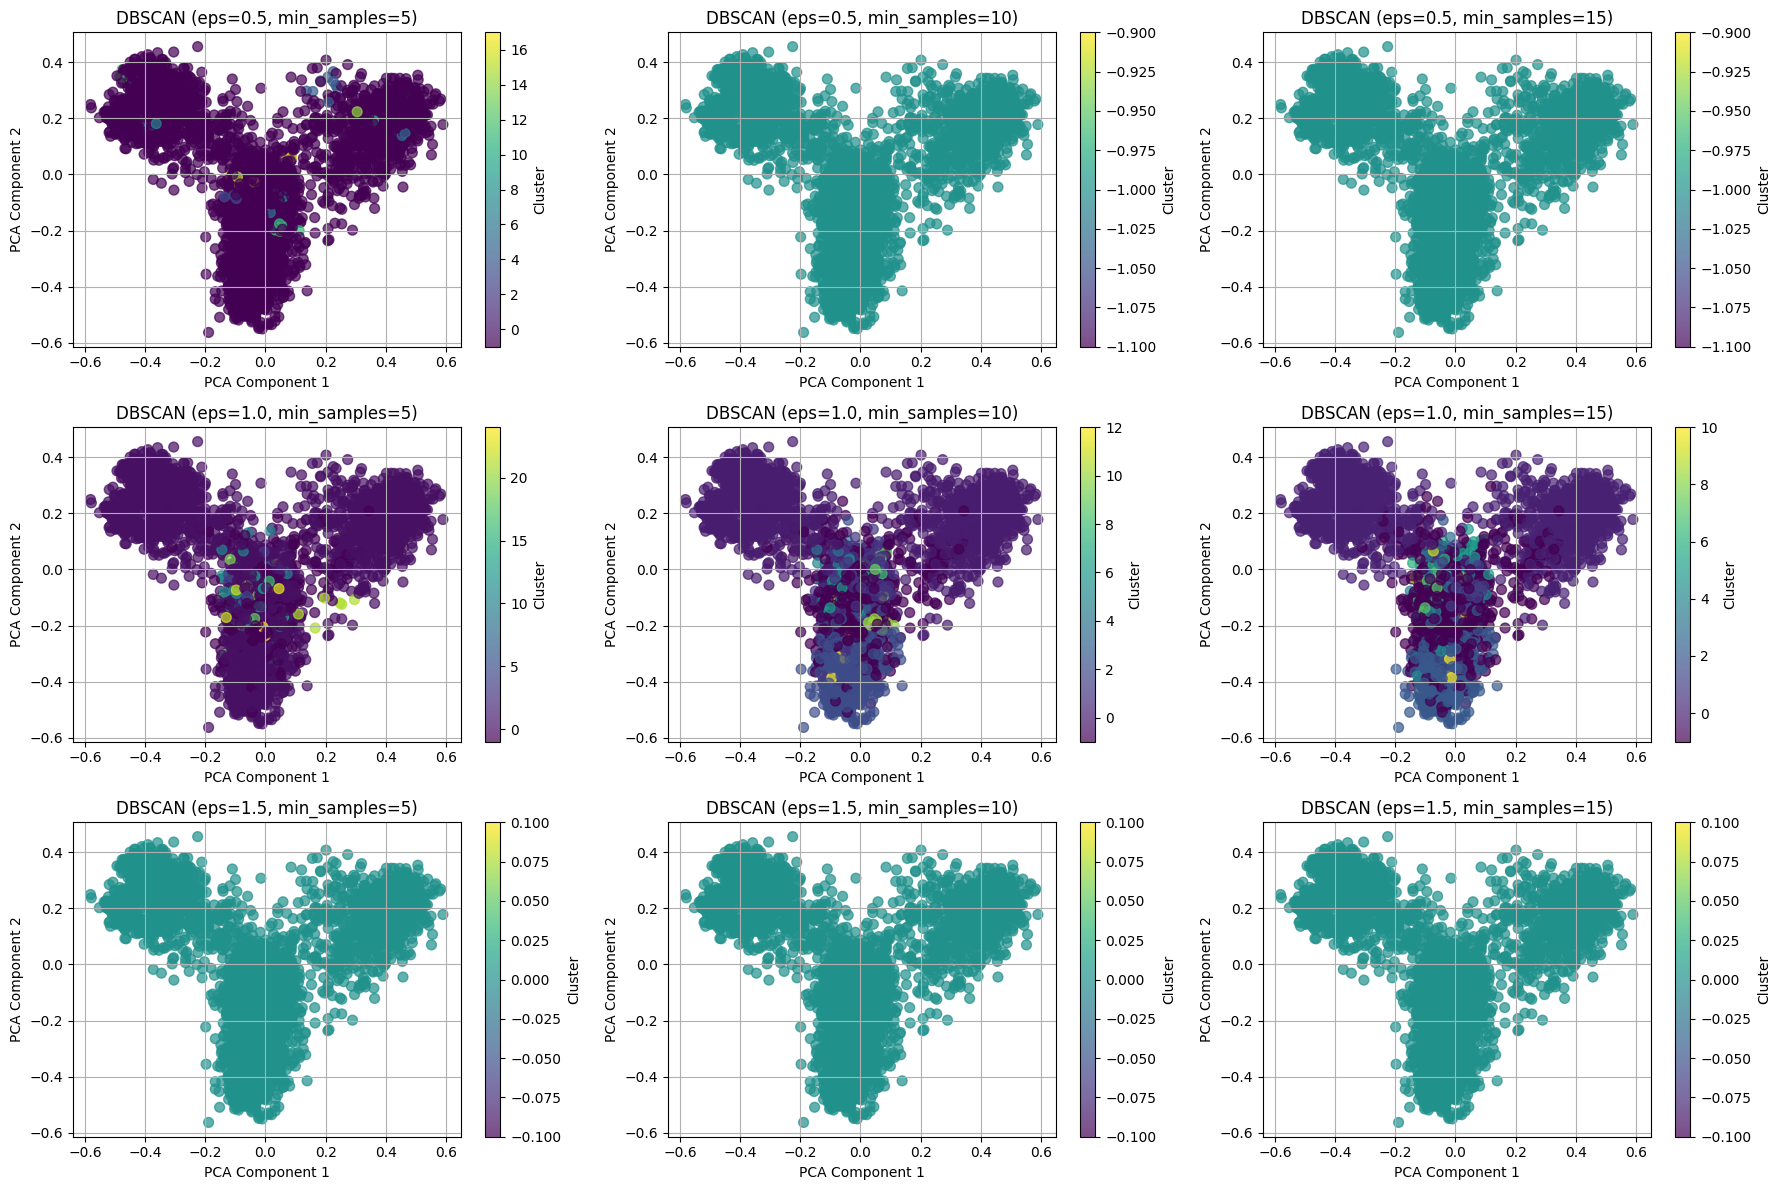

                                                Text  \
0                                           document   
1  From: melabdel@cobra.cs.unm.edu (Mohammed Elab...   
2  From: bc744@cleveland.Freenet.Edu (Mark Ira Ka...   
3  From: lundby@rtsg.mot.com (Walter F. Lundby)\n...   
4  From: ajs8@kimbark.uchicago.edu (adam jeremy s...   

   DBSCAN_Cluster_eps0.5_min5  
0                          -1  
1                           0  
2                          -1  
3                          -1  
4                          -1  


In [14]:

# Reduce dimensionality for visualization using PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(feature_matrix)

# Function to fit DBSCAN and plot clusters
def fit_and_plot_dbscan(data, feature_matrix, eps, min_samples, title):
    # Fit DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(feature_matrix)
    
    # Add cluster labels to the dataset
    data[f'DBSCAN_Cluster_eps{eps}_min{min_samples}'] = clusters
    
    # Plot the clusters
    plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis', s=50, alpha=0.7)
    plt.title(title)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.colorbar(label="Cluster")
    plt.grid(True)

# Test different values of eps and min_samples
eps_values = [0.5, 1.0, 1.5]  # Adjust based on your dataset
min_samples_values = [5, 10, 15]  # Adjust based on your dataset

# Plot DBSCAN clustering results for different eps and min_samples
plt.figure(figsize=(18, 12))

for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_samples_values):
        # Add subplot for current eps and min_samples
        plt.subplot(len(eps_values), len(min_samples_values), i * len(min_samples_values) + j + 1)
        fit_and_plot_dbscan(data, feature_matrix, eps, min_samples, f"DBSCAN (eps={eps}, min_samples={min_samples})")

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

# Display the first few rows with cluster assignments
print(data[['Text', 'DBSCAN_Cluster_eps0.5_min5']].head())

### Hierarchical:

First 5 rows with cluster assignments:
                                                Text  Cluster_3
0                                           document          0
1  From: melabdel@cobra.cs.unm.edu (Mohammed Elab...          2
2  From: bc744@cleveland.Freenet.Edu (Mark Ira Ka...          2
3  From: lundby@rtsg.mot.com (Walter F. Lundby)\n...          0
4  From: ajs8@kimbark.uchicago.edu (adam jeremy s...          0


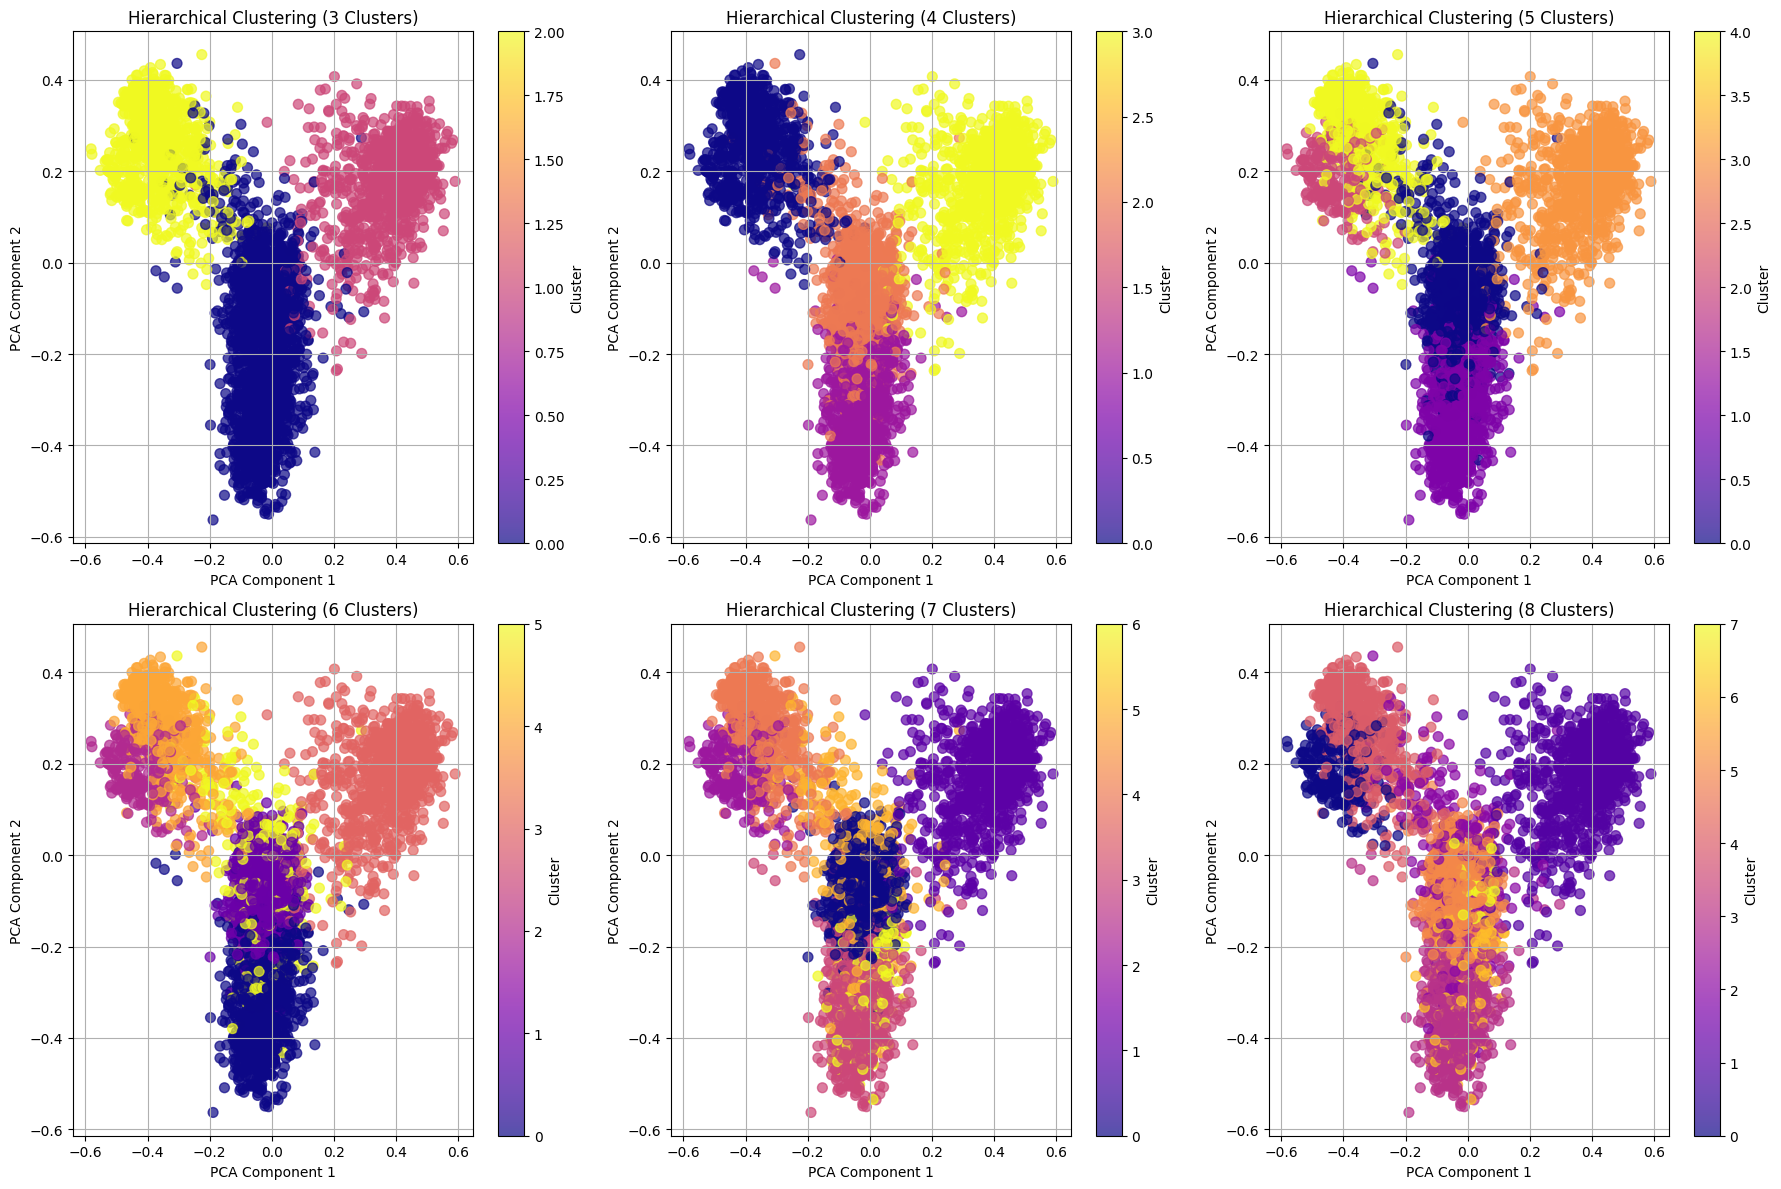

In [ ]:
# Reduce dimensionality for visualization using PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(feature_matrix)

# Function to apply hierarchical clustering and store results
def apply_hierarchical_clustering(data, features, num_clusters, cluster_column):
    # Fit Agglomerative Clustering
    clustering_model = AgglomerativeClustering(n_clusters=num_clusters, metric='euclidean', linkage='ward')
    cluster_labels = clustering_model.fit_predict(features)
    
    # Add cluster labels to the dataset
    data[cluster_column] = cluster_labels
    return cluster_labels

# Define configurations for clustering
clustering_configurations = [
    {"num_clusters": 3, "cluster_column": "Cluster_3"},
    {"num_clusters": 4, "cluster_column": "Cluster_4"},
    {"num_clusters": 5, "cluster_column": "Cluster_5"},
    {"num_clusters": 6, "cluster_column": "Cluster_6"},
    {"num_clusters": 7, "cluster_column": "Cluster_7"},
    {"num_clusters": 8, "cluster_column": "Cluster_8"}
]

# Apply clustering for each configuration
for config in clustering_configurations:
    apply_hierarchical_clustering(data, feature_matrix, config["num_clusters"], config["cluster_column"])

# Display the first few rows with cluster assignments
print("First 5 rows with cluster assignments:")
print(data[['Text', 'Cluster_3']].head())

# Plot clustering results for different numbers of clusters
plt.figure(figsize=(18, 12))

for idx, config in enumerate(clustering_configurations):
    # Add subplot for current number of clusters
    plt.subplot(2, 3, idx + 1)
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=data[config["cluster_column"]], cmap='plasma', s=50, alpha=0.7)
    plt.title(f"Hierarchical Clustering ({config['num_clusters']} Clusters)")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.colorbar(label="Cluster")
    plt.grid(True)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

### Compare Clustering Outputs
Visualize and compare the clustering results using PCA for dimensionality reduction:

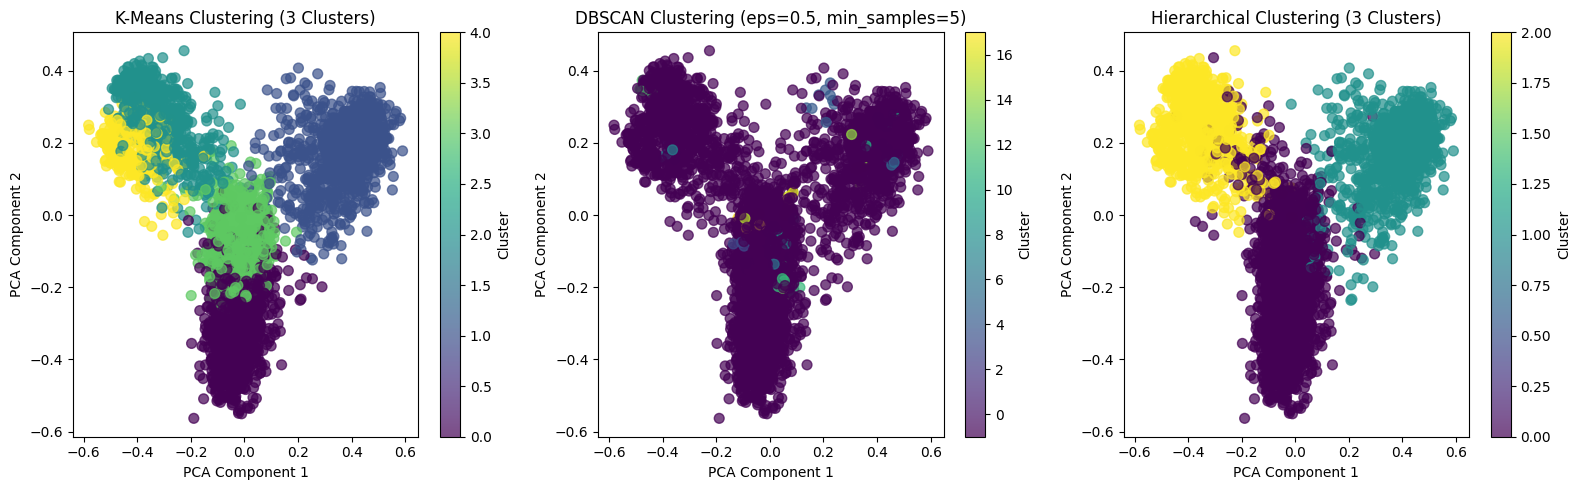

In [43]:
# Reduce feature matrix to 2D for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(feature_matrix)

# Plot clusters for each method
plt.figure(figsize=(16, 5))

# K-Means
plt.subplot(1, 3, 1)
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=data['KMeans_Cluster'], cmap='viridis', s=50, alpha=0.7)
plt.title("K-Means Clustering (3 Clusters)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")

# DBSCAN
plt.subplot(1, 3, 2)
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=data['DBSCAN_Cluster_eps0.5_min5'], cmap='viridis', s=50, alpha=0.7)
plt.title("DBSCAN Clustering (eps=0.5, min_samples=5)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")

# Hierarchical
plt.subplot(1, 3, 3)
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=data['Cluster_3'], cmap='viridis', s=50, alpha=0.7)
plt.title("Hierarchical Clustering (3 Clusters)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

10.
**What is PCA?**
**Principal Component Analysis (PCA)** is a dimensionality reduction technique used to transform high-dimensional data into a lower-dimensional space while retaining as much variance (information) as possible.

---

**Functionality of PCA**:
1. **Dimensionality Reduction**:
   - Reduces the number of features (dimensions) in the dataset by projecting the data onto a set of orthogonal axes called **principal components**.

2. **Variance Retention**:
   - The first principal component captures the most variance in the data, the second captures the second most, and so on.

3. **Orthogonality**:
   - Principal components are orthogonal (uncorrelated), ensuring that each component provides unique information.

4. **Applications**:
   - Used for visualization, noise reduction, and improving computational efficiency in machine learning.

---

**How It Works**:
1. Standardize the data (mean = 0, variance = 1).
2. Compute the covariance matrix of the data.
3. Perform eigenvalue decomposition on the covariance matrix to find the principal components.
4. Project the data onto the top `k` principal components (where `k` is the desired number of dimensions).

---

**Key Benefit**:
PCA simplifies complex datasets while preserving the most important patterns, making it easier to visualize and analyze.

Reduced Feature Matrix Shape: (3898, 2)


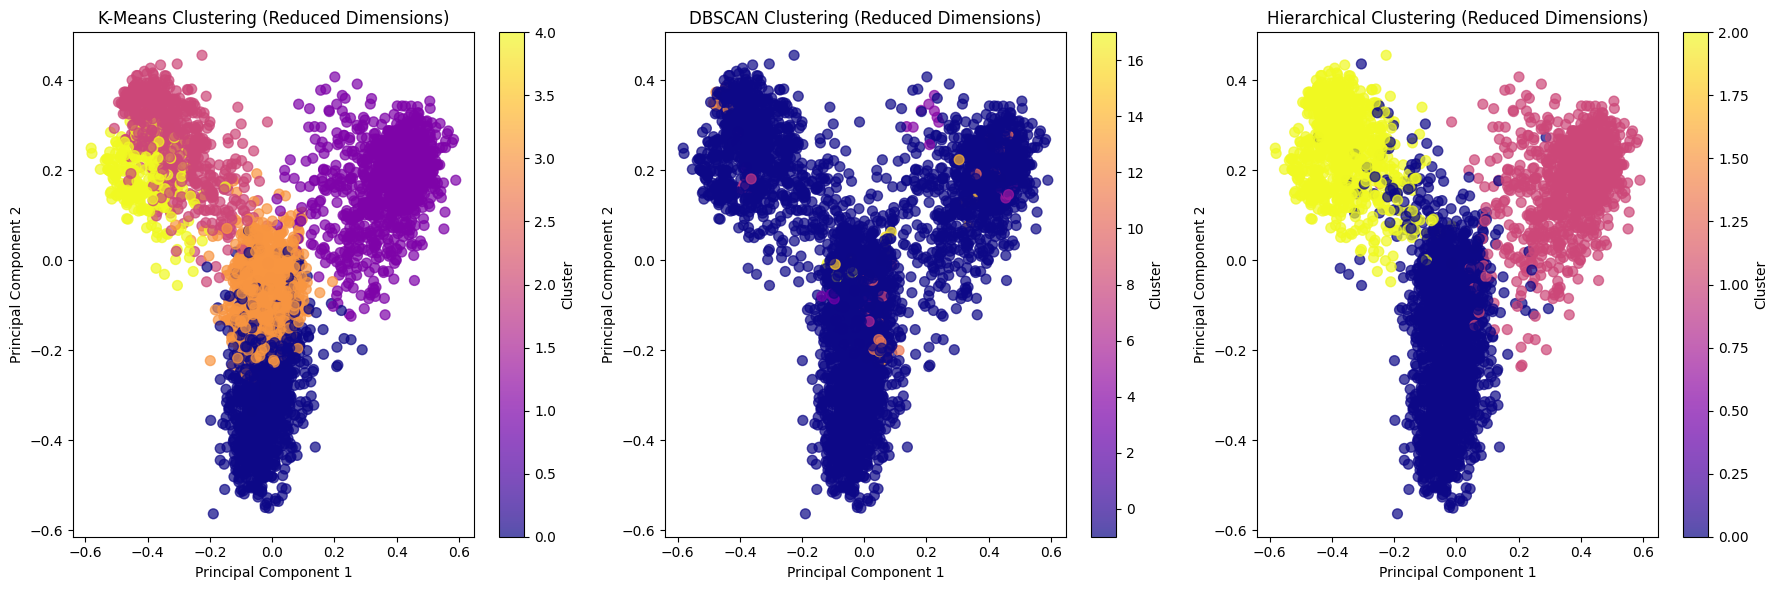

In [ ]:
# Apply PCA to reduce the feature matrix to 2D
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(feature_matrix)

# Print the shape of the reduced feature matrix
print("Reduced Feature Matrix Shape:", reduced_features.shape)

# Plot clusters for each clustering method
plt.figure(figsize=(18, 6))

# K-Means Clustering
plt.subplot(1, 3, 1)
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=data['KMeans_Cluster'], cmap='plasma', s=50, alpha=0.7)
plt.title("K-Means Clustering (Reduced Dimensions)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster")

# DBSCAN Clustering
plt.subplot(1, 3, 2)
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=data['DBSCAN_Cluster_eps0.5_min5'], cmap='plasma', s=50, alpha=0.7)
plt.title("DBSCAN Clustering (Reduced Dimensions)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster")

# Hierarchical Clustering
plt.subplot(1, 3, 3)
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=data['Cluster_3'], cmap='plasma', s=50, alpha=0.7)
plt.title("Hierarchical Clustering (Reduced Dimensions)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster")

plt.tight_layout()
plt.show()

### Silhouette Score for Clustering
1: Well-clustered.
0: Overlapping clusters.
-1: Misclustered.

Silhouette Score for K-Means: 0.07679741829633713
Silhouette Score for DBSCAN: -0.13446371257305145
Silhouette Score for Hierarchical Clustering: 0.07375334948301315


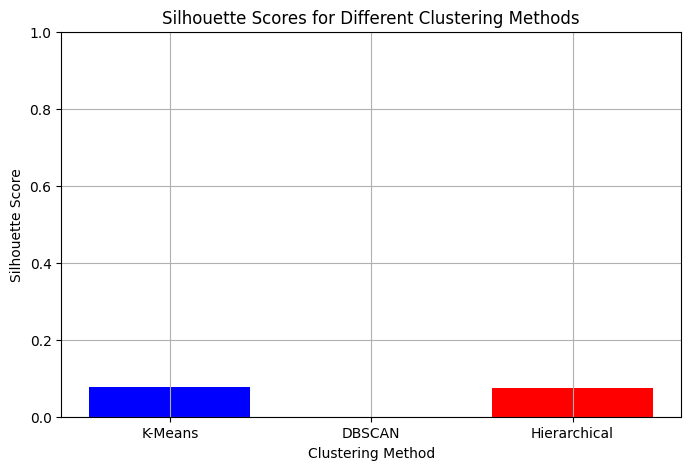

In [41]:
# Function to compute silhouette score
def compute_silhouette_score(feature_matrix, labels):
    if len(set(labels)) > 1:  # Silhouette score requires at least 2 clusters
        return silhouette_score(feature_matrix, labels)
    else:
        return None  # Return None if only one cluster exists

# Compute silhouette scores for each clustering method
kmeans_score = compute_silhouette_score(feature_matrix, data['KMeans_Cluster'])
dbscan_score = compute_silhouette_score(feature_matrix, data['DBSCAN_Cluster_eps0.5_min5'])
hierarchical_score = compute_silhouette_score(feature_matrix, data['Cluster_3'])

# Print silhouette scores
print(f"Silhouette Score for K-Means: {kmeans_score}")
print(f"Silhouette Score for DBSCAN: {dbscan_score}")
print(f"Silhouette Score for Hierarchical Clustering: {hierarchical_score}")

# Plot silhouette scores
plt.figure(figsize=(8, 5))
scores = [kmeans_score, dbscan_score, hierarchical_score]
methods = ['K-Means', 'DBSCAN', 'Hierarchical']
plt.bar(methods, scores, color=['blue', 'green', 'red'])
plt.title("Silhouette Scores for Different Clustering Methods")
plt.xlabel("Clustering Method")
plt.ylabel("Silhouette Score")
plt.ylim(0, 1)  # Silhouette score ranges from -1 to 1
plt.grid(True)
plt.show()

### Three sample documents 

In [47]:
def print_cluster_samples(data, cluster_column, num_samples=3):
    clusters = data[cluster_column].unique()
    print(f"\nCluster Samples for {cluster_column}:\n")
    for cluster in clusters:
        if cluster == -1:  # Skip noise in DBSCAN
            print(f"\nNoise Cluster (Cluster -1):\n")
        else:
            print(f"\nCluster {cluster}:\n")
        samples = data[data[cluster_column] == cluster]['Text'].sample(n=min(num_samples, len(data[data[cluster_column] == cluster])))
        for sample in samples:
            print(sample)
            print("-" * 80)

# Print samples for each clustering method
print_cluster_samples(data, 'KMeans_Cluster')
print_cluster_samples(data, 'DBSCAN_Cluster_eps0.5_min5')  # Corrected column name
print_cluster_samples(data, 'Cluster_3')  # Corrected column name


Cluster Samples for KMeans_Cluster:


Cluster 0:

From: robert@slipknot.rain.com (Robert Reed)
Subject: Re: ACM SIGGRAPH (and ACM in general)
Reply-To: Robert Reed <robert@slipknot.rain.com>
Organization: Home Animation Ltd.
Lines: 50

In article <1993Apr29.023508.11556@koko.csustan.edu> rsc@altair.csustan.edu (Steve Cunningham) writes:
|
|And no, SIGGRAPH 93 has not skipped town -- we're preparing the best
|SIGGRAPH conference yet!

Speaking of SIGGRAPH, I just went through the ordeal of my annual registration
for SIGGRAPH and re-upping of membership in the ACM last night, and was I ever
grossed out!  The new prices for membership are almost highway robbery!

For example:

	SIGGRAPH basic fee went from $26 last year to $59 this year for the same
	thing, a 127% increase.  Those facile enough to arrange a trip to the
	annual conference could reduce this to $27 by selecting SIGGRAPH Lite,
	which means SIGGRAPH is charging an additional $32 (or so) for the
	proceedings and the art show c

### Homogeneity

In [48]:

# Assuming you have a 'True_Label' column in your data
if 'True_Label' in data.columns:
    kmeans_homogeneity = homogeneity_score(data['True_Label'], data['KMeans_Cluster'])
    dbscan_homogeneity = homogeneity_score(data['True_Label'], data['DBSCAN_Cluster'])
    hierarchical_homogeneity = homogeneity_score(data['True_Label'], data['Hierarchical_Cluster'])

    print(f"K-Means Homogeneity Score: {kmeans_homogeneity}")
    print(f"DBSCAN Homogeneity Score: {dbscan_homogeneity}")
    print(f"Hierarchical Clustering Homogeneity Score: {hierarchical_homogeneity}")
